In [1]:
## Deconvolution into discrete subpopulations using a general mixture model (GMM)

## Imports and variables
import glob
import os
import sys 
from tqdm import tqdm
from pathlib import Path
import numpy as np

# Path hidpy
sys.path.append('%s/../' % os.getcwd())

from deconvolution import applyGMM_functions
from deconvolution import applyGMMconstrained_fitout_functions
from deconvolution import importDeconvolutionGMM

BayesMat={} # Dictionary with all the Bayes struct per cell
numDist = 3 # Choose maximum number of distributions

pathBayesCells = '%s/../output-protocol/sim/pickle/' % os.getcwd()
parameters2decon=['D','A','V']

nbins=20

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


['/ssd1/projects/hidpy/notebooks/../output-protocol/sim/pickle//sim_pixel-0.04_dt-2.00_threshold_50.pickle']


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


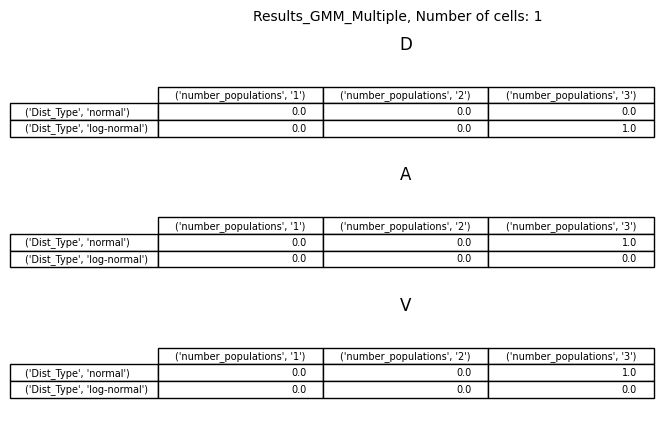

In [2]:
## Deconvolution GMM

listdir=glob.glob(pathBayesCells+'*.pickle')  # Read cell pickle files

import os
files = list()
for file in os.listdir(pathBayesCells):
    if file.endswith(".pickle"):
        files.append(file)

for i in range(len(files)):
    files[i] = '%s/%s' % (pathBayesCells, files[i])

listdir = files
print(files)

BayesMat=importDeconvolutionGMM.applyGMM_Multiple(listdir,parameters2decon,numDist) # Apply GMM
pathBayesCells_GMM_Multiple=pathBayesCells+'/GMM_Multiple/'

try: 
    os.mkdir(pathBayesCells_GMM_Multiple)
except: 
    print('WARNING: The output path [%s] exists' %pathBayesCells_GMM_Multiple)
    [f.unlink() for f in Path(pathBayesCells_GMM_Multiple).glob("*") if f.is_file()] 

importDeconvolutionGMM.generatetable_TestGMM(pathBayesCells_GMM_Multiple,BayesMat,parameters2decon) # Make Table

In [3]:
def sample_range(start,
                 end,
                 steps):

    # Delta
    delta = 1. * (end - start) / (steps - 1)

    # Data
    data = list()
    for i in range(steps):
        value = start + i * delta
        data.append(value)

    return data

def generateplots_TestGMM_outliers(pathBayesCells_Plots,BayesMat, parameters,nbins,showplots):

    import numpy as np
    import pickle
    from tqdm import tqdm
    import os
    import pandas as pd
    from matplotlib import pyplot as plt
    from scipy.stats import iqr
    from matplotlib import colors

    import seaborn
    from matplotlib import pyplot
    import matplotlib.pyplot as pyplot
    import matplotlib.font_manager as font_manager
    from matplotlib.ticker import FuncFormatter

    
    
    font_size = 14
    #seaborn.set_style("whitegrid")
    pyplot.rcParams['axes.grid'] = 'False'
    pyplot.rcParams['grid.linewidth'] = 1.0
    pyplot.rcParams['grid.color'] = 'black'
    pyplot.rcParams['grid.alpha'] = 1.0
    pyplot.rcParams['font.family'] = 'Helvetica LT Std'
    pyplot.rcParams['font.family'] = 'NimbusSanL'
    pyplot.rcParams['font.monospace'] = 'Regular'
    pyplot.rcParams['font.style'] = 'normal'
    pyplot.rcParams['axes.labelweight'] = 'light'
    pyplot.rcParams['axes.linewidth'] = 1.0
    pyplot.rcParams['axes.labelsize'] = font_size
    pyplot.rcParams['xtick.labelsize'] = font_size
    pyplot.rcParams['ytick.labelsize'] = font_size
    pyplot.rcParams['legend.fontsize'] = font_size
    pyplot.rcParams['figure.titlesize'] = font_size
    pyplot.rcParams['axes.titlesize'] = font_size

    pyplot.rcParams['axes.edgecolor'] = '1'

    for i in tqdm(range(len(BayesMat))):

        # Get the file name 
        file_name = BayesMat[i]['filename']
        
        # File name without extension 
        filename_without_ext = os.path.splitext(file_name)[0]

        colors = ['r', 'g', 'b']
        figure_width = 8
        figure_height = 3
        # Create the new plot 
        fig, axs = plt.subplots(1, len(parameters), figsize=(figure_width, figure_height))
        fig.clf
        fig.suptitle('Result') #'Filename: '+os.path.basename(filename_without_ext), fontsize=10)
 
        # For every parameter that should be deconvolved 
        for i_paramter in range(len(parameters)):

            # Get the parameter that needs analysis 
            parameter2analyse = parameters[i_paramter]
            
            # Lists 
            xdata = list()
            x = list()

            # MAGIC
            xdata = BayesMat[i][parameter2analyse].reshape(-1, 1)
            xdata[np.where(np.isnan(xdata))] = 0
            xdata = xdata[np.where(xdata > 1e-10)]

            if 'D' in parameter2analyse:
                data_filtered = list()
                for xxx in xdata:
                    if xxx < 0.0021:
                        data_filtered.append(xxx)
                xdata = data_filtered
            
            # Construct the histogram 
            n, bins, patches = axs[i_paramter].hist(xdata, edgecolor=colors[i_paramter], color=colors[i_paramter], density=True, bins=nbins, alpha=0.2)
            x = np.arange(min(bins), max(bins), bins[1] - bins[0])


            weights = BayesMat[i]['Deconvolution'][parameter2analyse]['weights']
            mu = BayesMat[i]['Deconvolution'][parameter2analyse]['mu']
            sigma = BayesMat[i]['Deconvolution'][parameter2analyse]['sigma']
            DistributionType = BayesMat[i]['Deconvolution'][parameter2analyse]['DistributionType']
            number_populations = BayesMat[i]['Deconvolution'][parameter2analyse]['number_populations']
            model0 = BayesMat[i]['Deconvolution'][parameter2analyse]['model']
            
            axs[i_paramter].set_title('') #'DistType: '+DistributionType + ', # Populations: '+str(number_populations),fontsize=6)
            axs[i_paramter].set_xlabel(parameter2analyse, fontsize=10)
            
            axs[i_paramter].xaxis.set_tick_params(labelsize=font_size)
            axs[i_paramter].yaxis.set_tick_params(labelsize=font_size)

            axs[i_paramter].xaxis.set_visible(True)
            axs[i_paramter].yaxis.set_visible(True)

            axs[i_paramter].spines['top'].set_color('none')
            axs[i_paramter].spines['right'].set_color('none')

            # Adjust the spines
            axs[i_paramter].spines["bottom"].set_color('black')
            axs[i_paramter].spines['bottom'].set_linewidth(1)
            axs[i_paramter].spines["left"].set_color('black')
            axs[i_paramter].spines['left'].set_linewidth(1)

            # Plot the ticks
            axs[i_paramter].tick_params(axis='x', width=1, which='both', bottom=True, direction="out")
            axs[i_paramter].tick_params(axis='y', width=1, which='both', left=True, direction="out")

            if 'D' in parameter2analyse:
                xticks = sample_range(min(bins), max(bins), 3)
                axs[i_paramter].set_xlim(0, 0.002)
                axs[i_paramter].set_xticks(xticks)
            elif 'A' in parameter2analyse:
                xticks = sample_range(min(bins), max(bins), 3)
                axs[i_paramter].set_xlim(0, 1.0)
                axs[i_paramter].set_xticks(xticks)
            else:
                xticks = sample_range(min(bins), max(bins), 3)
                axs[i_paramter].set_xlim(xticks[0], xticks[-1])
                axs[i_paramter].set_xticks(xticks)

            from matplotlib.ticker import FormatStrFormatter
            axs[i_paramter].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

            import math
            difference = axs[i_paramter].get_ylim()[1] - axs[i_paramter].get_ylim()[0]
            yticks = sample_range(axs[i_paramter].get_ylim()[0], axs[i_paramter].get_ylim()[1] + (difference * 0.1), 4)
            axs[i_paramter].set_ylim(yticks[0], yticks[-1])
            axs[i_paramter].set_yticks(yticks)

            #axs[i_paramter].set_ylim(yticks[0], yticks[-1])

            
            tempval=np.zeros(x.shape)

            if DistributionType == 'normal':
                for d in range(int(number_populations)):
                    axs[i_paramter].plot(x, weights[d]*applyGMM_functions.normal(x, mu[d], sigma[d]))
                    tempval= tempval+weights[d]*applyGMM_functions.normal(x, mu[d], sigma[d])
                axs[i_paramter].plot(x, tempval,'k')

            else:
                if number_populations==1:
                    param = model0.parameters
                    axs[i_paramter].plot(x, weights[0]*applyGMM_functions.lognormal(x,param[0],param[1]))
                else:
                    for d in range(int(number_populations)):           
                        param = model0.distributions[d].parameters
                        axs[i_paramter].plot(x, weights[d]*applyGMM_functions.lognormal((x), param[0],param[1]))
                        tempval= tempval+weights[d]*applyGMM_functions.lognormal((x), param[0],param[1])
                    axs[i_paramter].plot(x, tempval,'k')

            fig.tight_layout(pad=0.5)
        
        fig.savefig(pathBayesCells_Plots+os.path.basename(filename_without_ext)+'.png', dpi=300, bbox_inches='tight', pad_inches=0)
        if not(showplots):
            close(fig)
    

  0%|          | 0/1 [00:00<?, ?it/s]findfont: Font family ['NimbusSanL'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NimbusSanL'] not found. Falling back to DejaVu Sans.
100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


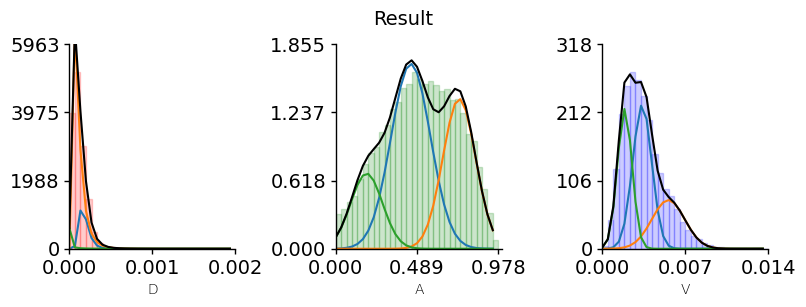

In [4]:
# Generating plots for inspection
from turtle import width


showplots=True

pathBayesCells_Plots=pathBayesCells_GMM_Multiple+'Plots_GMM_Multiple/'

try: 
    os.mkdir(pathBayesCells_Plots)
except: 
    print('WARNING: The output path [%s] exists' %pathBayesCells_Plots)
    [f.unlink() for f in Path(pathBayesCells_Plots).glob("*") if f.is_file()] 

generateplots_TestGMM_outliers(pathBayesCells_Plots, BayesMat, parameters2decon, 30, showplots)

#importDeconvolutionGMM.generateplots_TestGMM(pathBayesCells_Plots, BayesMat, parameters2decon, nbins, showplots)

In [5]:
# Run GMM based on table and plots for each parameter [D A V]

Sel_DistributionType=['lognormal','normal','lognormal']
Sel_numDist=[3,3,2]

BayesMatSel=importDeconvolutionGMM.applyGMMconstrained_dir(listdir,parameters2decon,Sel_DistributionType,Sel_numDist)


100%|██████████| 1/1 [00:03<00:00,  3.29s/it]


Verify Package!


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


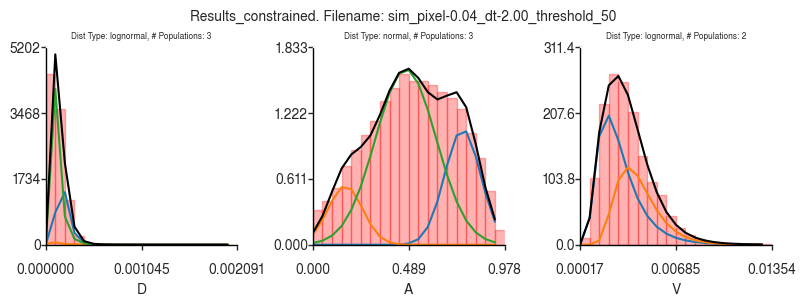

In [6]:
# Generate plots GMM constrained

pathGMMConstrained=pathBayesCells+'/GMM_Constrained/'
try: 
    os.mkdir(pathGMMConstrained)
except: 
    print('WARNING: The output path [%s] exists' %pathGMMConstrained)
    [f.unlink() for f in Path(pathGMMConstrained).glob("*") if f.is_file()]

pathBayesCells_Plots_constrained=pathGMMConstrained+'/Plots_GMM_Constrained/'
showplots=True
try: 
    os.mkdir(pathBayesCells_Plots_constrained)
except: 
    print('WARNING: The output path [%s] exists' %pathBayesCells_Plots_constrained)
    [f.unlink() for f in Path(pathBayesCells_Plots_constrained).glob("*") if f.is_file()]


importDeconvolutionGMM.generateplots_GMMconstrained_fitout(pathBayesCells_Plots_constrained,BayesMatSel,parameters2decon,nbins,Sel_DistributionType,Sel_numDist,showplots)


  0%|          | 0/1 [00:00<?, ?it/s]

Verify Package!
Verify Package!


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Verify Package!


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


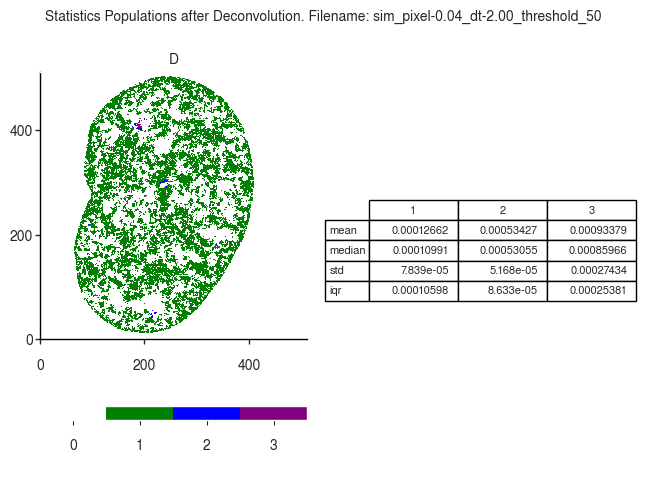

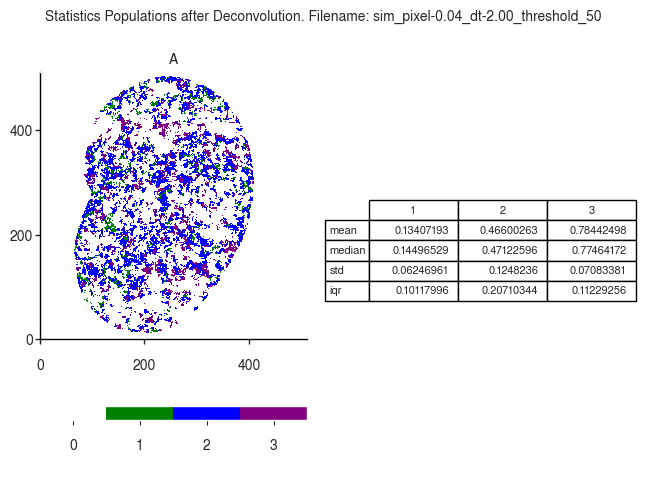

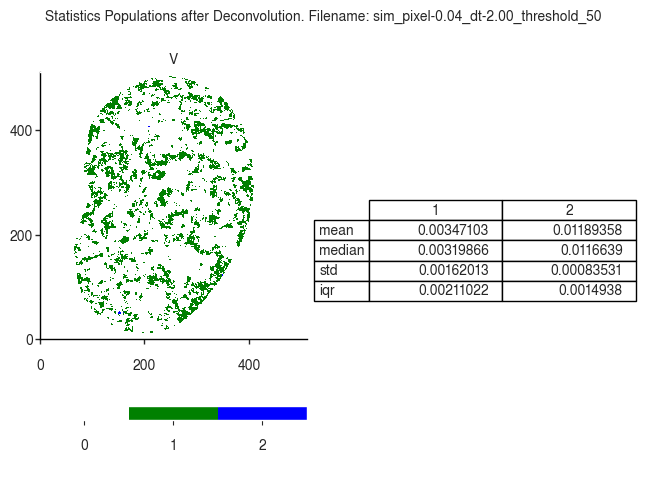

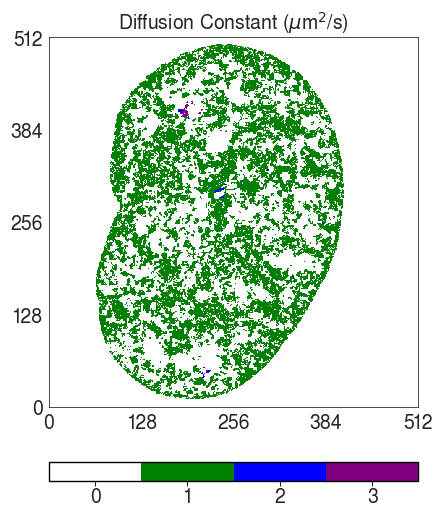

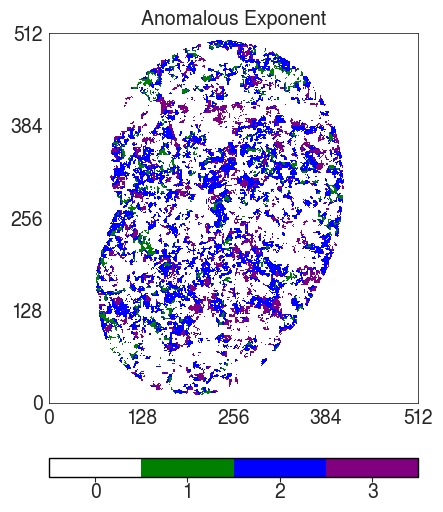

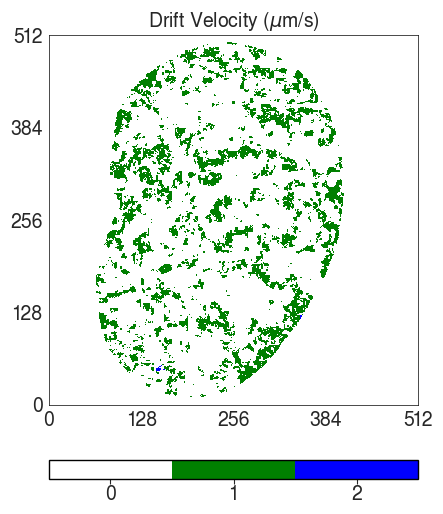

In [10]:
# Generate spatial mapping of population deconvolution

pathBayesCells_Populations_Plots=pathGMMConstrained+'/Populations_Plots_Stats/'
try: 
    os.mkdir(pathBayesCells_Populations_Plots)
except: 
    print('WARNING: The output path [%s] exists' %pathBayesCells_Populations_Plots)
    [f.unlink() for f in Path(pathBayesCells_Populations_Plots).glob("*") if f.is_file()]
    

showplots=True

####################################################################################################
# @sample_range
####################################################################################################
def sample_range(start,
                 end,
                 steps):

    # Delta
    delta = 1. * (end - start) / (steps - 1)

    # Data
    data = list()
    for i in range(steps):
        value = start + i * delta
        data.append(value)

    return data

def generate_plots_stats_decon(BayesMatSel,param,pathBayesCells_Populations_Plots,showplots):

    
    from matplotlib import colors, pyplot
    import seaborn
    font_size = 14
    import numpy
    seaborn.set_style("whitegrid")
    pyplot.rcParams['axes.grid'] = 'False'
    pyplot.rcParams['grid.linewidth'] = 0.5
    pyplot.rcParams['grid.color'] = 'black'
    pyplot.rcParams['grid.alpha'] = 0.25
    pyplot.rcParams['font.family'] = 'NimbusSanL'
    pyplot.rcParams['font.monospace'] = 'Regular'
    pyplot.rcParams['font.style'] = 'normal'
    pyplot.rcParams['axes.labelweight'] = 'light'
    pyplot.rcParams['axes.linewidth'] = 0.5
    pyplot.rcParams['axes.labelsize'] = font_size
    pyplot.rcParams['xtick.labelsize'] = font_size
    pyplot.rcParams['ytick.labelsize'] = font_size
    pyplot.rcParams['legend.fontsize'] = font_size
    pyplot.rcParams['figure.titlesize'] = font_size
    pyplot.rcParams['axes.titlesize'] = font_size
    pyplot.rcParams['xtick.major.pad'] = '1'
    pyplot.rcParams['ytick.major.pad'] = '1'
    pyplot.rcParams['axes.edgecolor'] = '0'
    pyplot.rcParams['axes.autolimit_mode'] = 'round_numbers'
    from matplotlib import colors, pyplot
    import seaborn

    import numpy
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]

    labels = BayesMatSel['Deconvolution'][param]['labels']
    unique_labels = np.unique(labels)
    thresh = []

    for label in unique_labels:
        data_in_label = BayesMatSel['Deconvolution'][param]['GMM_input'][labels==label]
        thresh.append( np.max(data_in_label))

    thresh = np.sort(thresh)[:-1] # the last entry is not actually a threshold

    # # for debugging - can be commented
    # plt.plot(BayesMatSel[cell_id]['Deconvolution'][param]['x'], \
    #     BayesMatSel[cell_id]['Deconvolution'][param]['p_pop'])
    # for i in range(len(thresh)):
    #     plt.plot((thresh[i], thresh[i]), (0, 1))

    # map distributions back to nucleus
    labels_map = np.zeros(BayesMatSel[param].shape, dtype=int)
    numPop = len(thresh)+1
    for t in range(numPop):
        assigned_label = t+1    
        if t == 0:
            labels_map[BayesMatSel[param]<=thresh[t]] = assigned_label
        elif t > 0 and t<numPop-1:
            labels_map[ np.logical_and(BayesMatSel[param]>thresh[t-1], BayesMatSel[param]<=thresh[t]) ] = assigned_label
        else:
            labels_map[BayesMatSel[param]>thresh[t-1]] = assigned_label
    labels_map[BayesMatSel[param]==0] = 0

    
    #fig,ax=plt.subplots(1,2,figsize=[10,5])
    # Plot 
    fig, ax = pyplot.subplots()
        
    listcolors=['w','g','b','purple','r','greenyellow']
    cmap = colors.ListedColormap(listcolors[0:numPop+1])

    # Create the ticks of the images 
    xticks = sample_range(0, labels_map.shape[0], 5)
    yticks = sample_range(0, labels_map.shape[1], 5)
    ax.set_xlim(xticks[0], xticks[-1])
    ax.set_ylim(yticks[0], yticks[-1])
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # Color-basr axis 
    cax = ax.inset_axes([0.00, -0.20, 1.0, 0.05])

    img1=ax.imshow(labels_map, interpolation='nearest', cmap=cmap,origin='lower')
    cbar=fig.colorbar(img1, cax=cax, ax=ax,spacing='proportional',orientation='horizontal',boundaries=[-0.5] + bounds[0:numPop+1] + [numPop+0.5])
    cbar.outline.set_color('black')
    cbar.outline.set_linewidth(1)
    labels_cbar = np.arange(0, numPop+1, 1)
    loc = labels_cbar
    cbar.set_ticks(loc)

    if 'D' in param:
        title = r'Diffusion Constant ($\mu$m$^2$/s)'
    elif 'A' in param:
        title = 'Anomalous Exponent'
    elif 'V' in param:
        title = r'Drift Velocity ($\mu$m/s)'

    #
    ax.set_title(title)

    output_directory=pathBayesCells
    frame_prefix=param

    # Save the figure 
    pyplot.savefig('%s/%s-output.png' % (output_directory, frame_prefix), dpi=300, bbox_inches='tight', pad_inches=0)

for i in tqdm(range(len(BayesMatSel))):
    for j in range(len(parameters2decon)):
         
        importDeconvolutionGMM.generate_plots_stats_decon(BayesMatSel[i],parameters2decon[j],pathBayesCells_Populations_Plots,showplots)
        # generate_plots_stats_decon(BayesMatSel[i],parameters2decon[j],pathBayesCells_Populations_Plots,showplots)

        #except:
        #    filename_without_ext = os.path.splitext(BayesMatSel[i]['filename'])[0]
        #    print('WARNING: Error generating population label plot: File: '+filename_without_ext+' Parameter: '+parameters2decon[j])

for i in tqdm(range(len(BayesMatSel))):
    for j in range(len(parameters2decon)):
         
        #importDeconvolutionGMM.generate_plots_stats_decon(BayesMatSel[i],parameters2decon[j],pathBayesCells_Populations_Plots,showplots)
        generate_plots_stats_decon(BayesMatSel[i],parameters2decon[j],pathBayesCells_Populations_Plots,showplots)

        #except:
        #    filename_without_ext = os.path.splitext(BayesMatSel[i]['filename'])[0]
        #    print('WARNING: Error generating population label plot: File: '+filename_without_ext+' Parameter: '+parameters2decon[j])
